# Installation

Detectron2:

In [ ]:
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
pip install opencv-python

Imports check:

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

Setup:

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utclities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

Register coco annotations:

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train", {}, "storage/train_annotations.json", "storage/train")
register_coco_instances("val", {}, "storage/val_annotations.json", "storage/val")

To verify the dataset is in correct format, let's visualize the annotations of randomly selected samples in the training set:



In [ ]:
train_metadata = MetadataCatalog.get('train')
train_dataset_dicts = DatasetCatalog.get("train")
from matplotlib import pyplot as plt
for d in random.sample(train_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# Training

In [52]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.000025
cfg.OUTPUT_DIR = "storage/output"
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset\
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[02/23 13:08:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir storage/output

# Inference

In [9]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[02/23 12:42:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from storage/output/model_final.pth ...
[Checkpointer] Loading from storage/output/model_final.pth ...


Then, we randomly select several samples to visualize the prediction results.

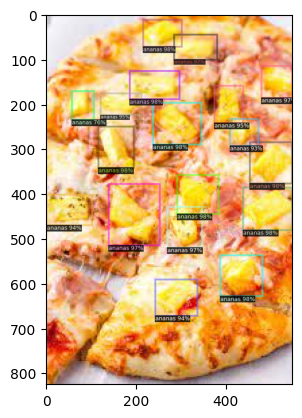

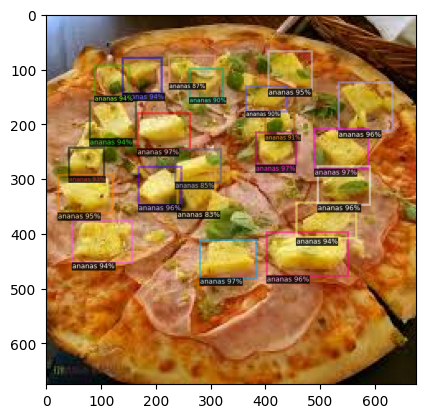

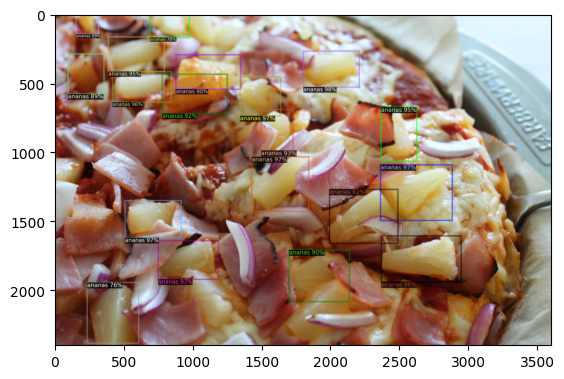

In [49]:
from detectron2.utils.visualizer import ColorMode
val_metadata = MetadataCatalog.get('val')
val_dataset_dicts = os.listdir("storage/pizzaa")
for d in random.sample(val_dataset_dicts, 3):
    im = cv2.imread("storage/pizzaa/" + d)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=3 # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite("storage/" + d, out.get_image()[:, :, ::-1]) 
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~45. Not great maybe due to small dataset!

In [53]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val", output_dir="storage/output")
val_loader = build_detection_test_loader(cfg, "val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[02/23 13:14:43 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[02/23 13:14:43 d2.data.datasets.coco]: Loaded 4 images in COCO format from storage/val_annotations.json
[02/23 13:14:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/23 13:14:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/23 13:14:43 d2.data.common]: Serializing 4 elements to byte tensors and concatenating them all ...
[02/23 13:14:43 d2.data.common]: Serialized dataset takes 0.00 MiB
[02/23 13:14:43 d2.evaluation.evaluator]: Start inference on 4 batches
[02/23 13:14:43 d2.evaluation.evaluator]: Total inference time: 0:00:00.135981 (0.135981 s / iter per device, on 1 devices)
[02/23 13:14:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.054298 s / iter per device, on 1